In [2]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from sph_modules import (compute_hsm, 
                         compute_hsm_tensor)

from pgpy import (cic_deposition, 
                  isotropic_kernel_deposition, 
                  anisotropic_kernel_deposition)

from web import compute_web

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
ds = pn.load('../../../../../shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_554.hdf5')


boxsize  = 15000
NN       = 16
periodic = True
gridnum  = 100
extent   = np.array([0, boxsize])

pos      = ds.gas['pos']
masses   = ds.gas['mass']


# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm = compute_hsm(pos, NN, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, NN, boxsize)


# stack all quantities to deposit
# dow we need to average the deposited quantities or not?
quantities = masses[:, np.newaxis]
averaged   = [False]
print(quantities.shape)

kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:555: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:394: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


(1949593, 1)


### sph-deposition (3d) and cosmic web classification using T-web
This notebook offers a walkthrough of depositing particle mass on 3d grids.
+ the particles in a simulation are deposited using a `deposition` strategy
+ the (over-) density field is classified using the `T-web` algorithm

In the following we compare different `deposition` strategies, namely `cic`, `isotropic` and `anisotropic` quintic kernel.\
Note the drastically increasing runtimes.

In [4]:

fields_cic, _ = cic_deposition(**kwargs)

#fields_ada, _ = cic_deposition(**kwargs, num_nn=NN)

fields_iso, _ = isotropic_kernel_deposition(**kwargs, hsm=hsm)

fields_ani, _ = anisotropic_kernel_deposition(**kwargs, hmat=hmat, evals=eλ, evecs=ev)


100%|██████████| 1949593/1949593 [29:35<00:00, 1097.76it/s] 


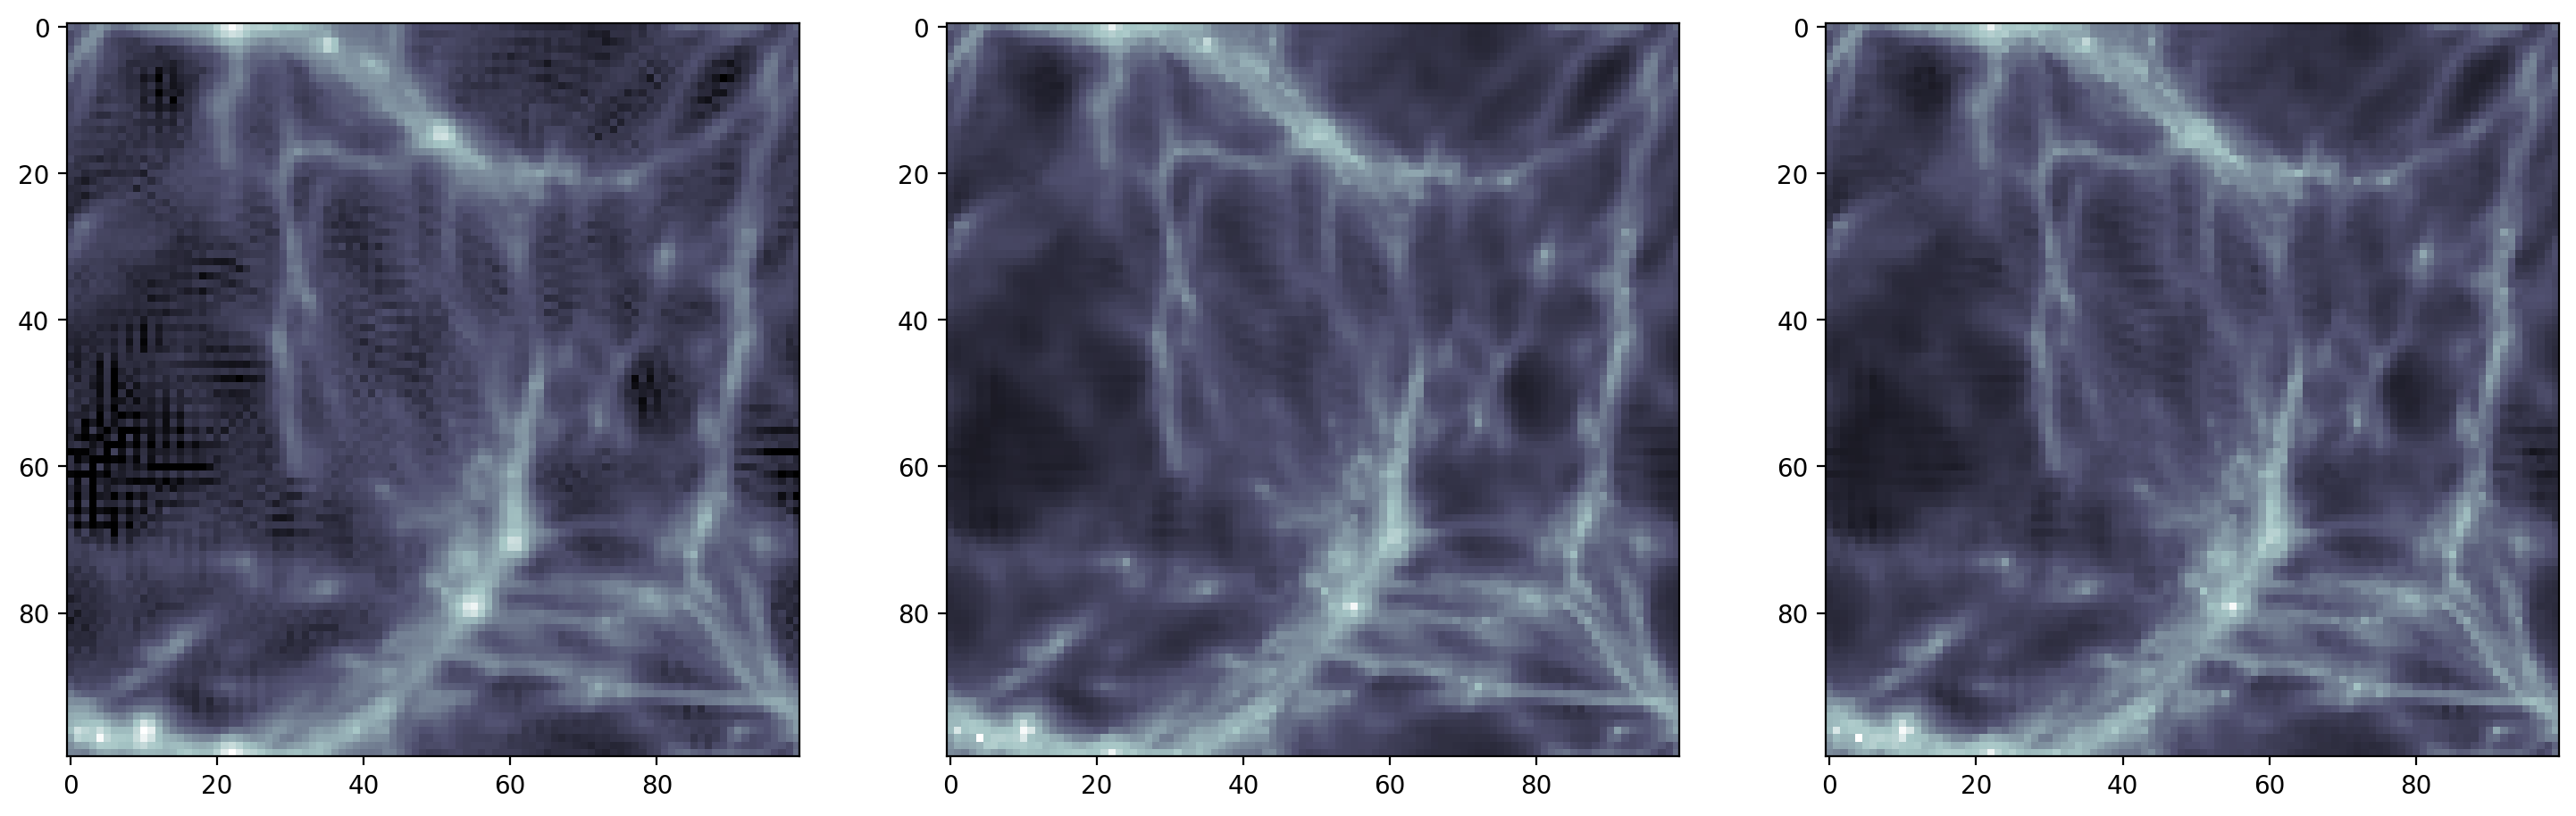

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18, 12))

ax[0].imshow(np.log10(fields_cic[:10,...,0].sum(axis=0)), cmap='bone', vmin=-3)
ax[1].imshow(np.log10(fields_iso[:10,...,0].sum(axis=0)), cmap='bone', vmin=-3)
ax[2].imshow(np.log10(fields_ani[:10,...,0].sum(axis=0)), cmap='bone', vmin=-3)

plt.show()

#### Cosmic web classification
The `T-web` algorithm is a simple comsic web classification scheme based on the eigenvalues of the tidal shear tensor (https://arxiv.org/abs/1705.03021).
\
\
The routine `compute_web` has the following steps:
1. Compute the overdensity field $\delta$ using a `deposition` strategy of the particle masses.
2. Solve the normalized poisson equation $\Delta \phi = \delta$
3. Compute the tidal shear tensor $T_{\alpha \beta} = \frac{\partial^2 \phi}{\partial x \partial y}$
4. Compute the eigenvalues of $T_{\alpha \beta}$
5. Assign to each voxel the correct label by comparing to $\lambda_{\text{th}}$ \
   `0: voids` \
   `1: sheets` \
   `2: filaments` \
   `3: knots`

\
Arguments: `mass_grid`= deposited mass on a 3d grid, `thresh`= $\lambda_{\text{th}}$\
Below we compare the resulting cosmic web depending on the `deposition` strategy.

Computing T...
Classifying web...
Computing T...
Classifying web...
Computing T...
Classifying web...


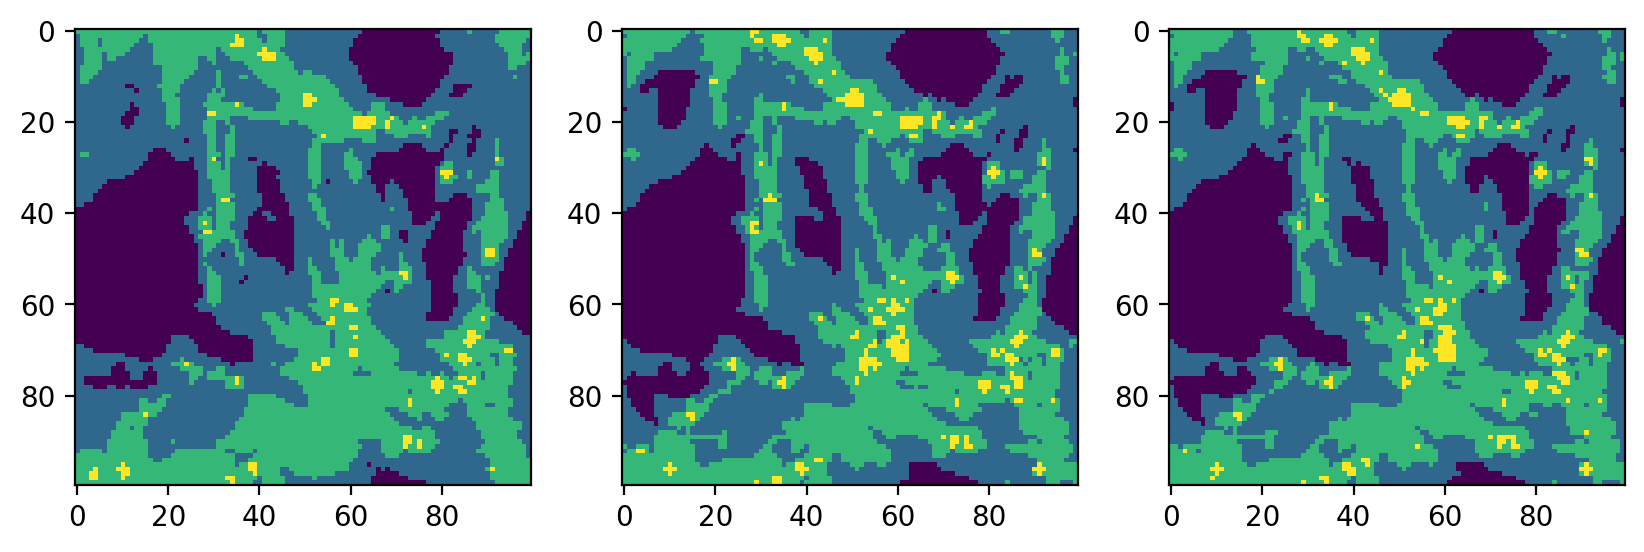

In [8]:
web_cic = compute_web(fields_cic[..., 0], thresh=0.2) # {nx, ny, nz, 1} -> {nx, ny, nz}
web_iso = compute_web(fields_iso[..., 0], thresh=0.2) # {nx, ny, nz, 1} -> {nx, ny, nz}
web_ani = compute_web(fields_ani[..., 0], thresh=0.2) # {nx, ny, nz, 1} -> {nx, ny, nz}


import matplotlib as mpl

cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 4, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(web_cic[:10, :, :].max(axis=0), cmap=cmap, norm=norm)
ax[1].imshow(web_iso[:10, :, :].max(axis=0), cmap=cmap, norm=norm)
ax[2].imshow(web_ani[:10, :, :].max(axis=0), cmap=cmap, norm=norm)

plt.savefig('plots/cosmic_web.png', transparent=True, dpi=300)
plt.show()